In [1]:
import random

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import normal
import scipy.stats
import sympy
import seaborn as sns
import pandas as pd
import numba
from scipy.stats import entropy
import os
import tempfile
import logging

from pyabc import ABCSMC, RV, Distribution
from pyabc.distance import AdaptivePNormDistance, PercentileDistance

from pyabc.sampler import SingleCoreSampler
from pyabc.visualization import plot_kde_1d, plot_kde_2d

from cnv_simulation import CNVsimulator_simpleWF, CNVsimulator_simpleChemo

First, define the simulator.  
N = population size  
s_cnv = fitness benefit of CNVs  
s_snv = fitness benefit of SNVs  
m_cnv = probability mutation to CNV  
m_snv = probability mutation to SNV


"Observed data"  
Using simulations with known parameters for observed data.  

In [2]:
# pop size, fitness SNVs, mutation rate SNVs, number of generations
N = 3e8
s_snv=0.002  # Venkataram et al. 2016
m_snv=1.67e-10 #SNV mutation rate: 1.67 x 10^-10 per base per generation (Zhu et al. 2014)
generation = np.array(range(0,268))
seed_true = 1
# true parameters
true_params = np.log10(np.array([.1, 1e-5]))
labels_params = ['CNV fitness effect', 'CNV mutation rate']

First, let's see how it does with Wright-Fisher

In [3]:
model="WF"
# our actual observation
data_observed_WF = CNVsimulator_simpleWF(N=N, s_snv=s_snv, m_snv=m_snv, generation=generation, seed=seed_true, cnv_params=true_params)
exp_gen = ['25', '33', '41', '54', '62', '70', '79', '87', '95', '103', '116',
       '124', '132', '145', '153', '161', '174', '182', '190', '211',
       '219', '232', '244', '257', '267']
dict_observed_WF = {}
i = 0
for keys in exp_gen: 
    dict_observed_WF[keys] = data_observed_WF[i]
    i+=1

Wrapper, pyABC requires simulation to return a dictionary

In [4]:
def simulate_pyabc(parameters, N=N, s_snv=s_snv, m_snv=m_snv, generation=generation, model=model):
    if model == "WF":
        res = CNVsimulator_simpleWF(N=N, s_snv=s_snv, m_snv=m_snv, generation=generation, parameters=parameters)
    if model == "Chemo":
        res = CNVsimulator_simpleChemo(A_inoc=A_inoc, S_init=S_init, k=k, D=D, μA=μA, m_snv=m_snv, s_snv=s_snv, I=I, y=y, τ=τ, parameters=parameters)
    exp_gen = ['25', '33', '41', '54', '62', '70', '79', '87', '95', '103', '116',
       '124', '132', '145', '153', '161', '174', '182', '190', '211',
       '219', '232', '244', '257', '267']
    pyabc_dict = {}
    i = 0
    for keys in exp_gen: 
        pyabc_dict[keys] = res[i]
        i+=1
    return pyabc_dict

Prior over model parameters. Model parameters are CNV fitness effects and CNV mutation rates. Will use a uniform distribution over the log of the priors.

In [5]:
prior = Distribution(
    s=RV("uniform", np.log10(1e-4), np.log10(0.3)-np.log10(1e-4)),
    m=RV("uniform", np.log10(1e-12), np.log10(1e-3)-np.log10(1e-12))
)

Create the ABCSMC object, given the model, the prior, and the distance function $\rho$, which we set to AdaptivePNormDistance which is the adaptive Euclidean distance.

In [6]:
abc = ABCSMC(models=simulate_pyabc,
             parameter_priors=prior,
             distance_function=AdaptivePNormDistance(p=2),
             sampler=SingleCoreSampler(),
             population_size=5000)

In [7]:
# and we define where to store the results
db_path_WF = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "WF.db"))
history_WF = abc.new(db_path_WF, dict_observed_WF)

INFO:History:Start <ABCSMC(id=6, start_time=2020-09-30 10:22:27.267240, end_time=None)>


In [8]:
print("ABC-SMC run ID:", history_WF.id)

ABC-SMC run ID: 6


In [9]:
# We run the ABC until either criterion is met
history_WF = abc.run(minimum_epsilon=0.2, max_nr_populations=5)

INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 1.8937664591278
INFO:ABC:t: 0, eps: 1.8937664591278.
INFO:ABC:Acceptance rate: 5000 / 9986 = 5.0070e-01, ESS=5.0000e+03.
INFO:ABC:t: 1, eps: 1.954740378510974.
INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:ABC:Acceptance rate: 5000 / 11114 = 4.4988e-01, ESS=4.6860e+03.
INFO:ABC:t: 2, eps: 0.8354575217547254.
INFO:ABC:Acceptance rate: 5000 / 10259 = 4.8738e-01, ESS=4.2222e+03.
INFO:ABC:t: 3, eps: 0.4700155117113778.
INFO:ABC:Acceptance rate: 5000 / 10070 = 4.9652e-01, ESS=4.6954e+03.
INFO:ABC:t: 4, eps: 0.13837670373889505.
INFO:ABC:Acceptance rate: 5000 / 9955 = 5.0226e-01, ESS=4.7493e+03.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=6, start_time=2020-09-30 10:22:27.267240, end_time=2020-09-30 10:34:37.361538)>


In [10]:
params, weights = history_WF.get_distribution(0)
params.head()

name,m,s
id,,
95007,-7.313801,-0.698584
95008,-7.797696,-0.785625
95009,-5.722500,-0.976858
95010,-4.950134,-0.966957
95011,-6.601721,-0.918947


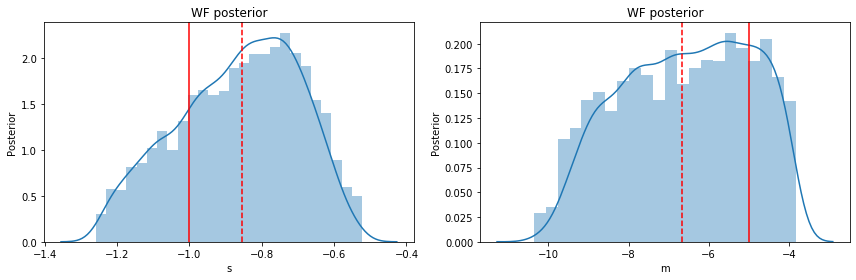

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for param_name, param_real_value, ax in zip(['s', 'm'], true_params, axes.flat):
    sns.distplot(params[param_name], hist_kws=dict(weights=weights), ax=ax)
    ax.axvline(param_real_value, color='red')
    ax.axvline(params[param_name].values @ weights, color='red', ls='--')
    ax.set(xlabel=param_name, ylabel='Posterior', title="WF posterior")

fig.tight_layout()

Optimization terminated successfully.
         Current function value: -1.237196
         Iterations: 30
         Function evaluations: 57


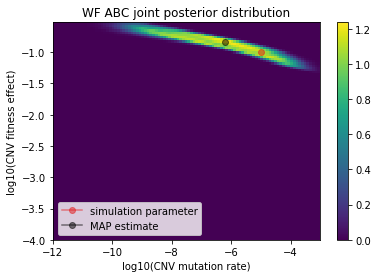

In [12]:
red, blue, green = sns.color_palette('Set1', 3)

prior_min = np.log10(np.array([1e-4,1e-12]))
prior_max = np.log10(np.array([0.3,1e-3]))

s_range, μ_range = np.mgrid[np.log10(1e-4):np.log10(0.3):100j, np.log10(1e-12):np.log10(1e-3):100j]
positions = np.vstack([s_range.ravel(), μ_range.ravel()])
values = np.vstack([params['s'], params['m']])
kernel = scipy.stats.gaussian_kde(values)
density = np.reshape(kernel(positions).T, s_range.shape)


#estimates for parameters from the posterior (MAP - highest probability in posterior)
idx = np.argmax(density, axis=None)
param_guess = np.array([positions[0,idx],positions[1,idx]])
def kernelminus(x):
    return -kernel(x)
s_est, μ_est = scipy.optimize.minimize(kernelminus,param_guess, method ='Nelder-Mead', 
 options={'disp': True}).x

#fig, axes = plt.subplots(1, 1, figsize=(10, 10))
plt.pcolormesh(μ_range, s_range, density)
plt.colorbar()
plt.plot(true_params[1],true_params[0], color=red, marker='o', label="simulation parameter", alpha=0.5)
plt.plot(μ_est, s_est, color="k", marker='o', label="MAP estimate", alpha=0.5)
plt.legend(loc='lower left')
plt.xlabel('log10(CNV mutation rate)')
plt.ylabel('log10(CNV fitness effect)')
plt.title("WF ABC joint posterior distribution")
plt.savefig("WF_ABC_posterior.pdf")

Now with a chemostat model  
Additional parameters describing the chemostat are needed for this model

In [13]:
A_inoc = 1e5
S_init = .800
D=0.12
μA=0.45
k=.103
y=3244500
I=.800
τ=1/10

model="Chemo"
# our actual observation
data_observed_Chemo = CNVsimulator_simpleChemo(A_inoc=A_inoc, S_init=S_init, k=k, D=D, μA=μA, m_snv=m_snv, s_snv=s_snv, I=I, y=y, τ=τ, seed=seed_true, cnv_params=true_params)
exp_gen = ['25', '33', '41', '54', '62', '70', '79', '87', '95', '103', '116',
       '124', '132', '145', '153', '161', '174', '182', '190', '211',
       '219', '232', '244', '257', '267']
dict_observed_Chemo = {}
i = 0
for keys in exp_gen: 
    dict_observed_Chemo[keys] = data_observed_Chemo[i]
    i+=1

Wrapper, pyABC requires simulation to return a dictionary

In [14]:
def simulate_pyabc(parameters, N=N, s_snv=s_snv, m_snv=m_snv, generation=generation, model=model):
    if model == "WF":
        res = CNVsimulator_simpleWF(N=N, s_snv=s_snv, m_snv=m_snv, generation=generation, parameters=parameters)
    if model == "Chemo":
        res = CNVsimulator_simpleChemo(A_inoc=A_inoc, S_init=S_init, k=k, D=D, μA=μA, m_snv=m_snv, s_snv=s_snv, I=I, y=y, τ=τ, parameters=parameters)
    exp_gen = ['25', '33', '41', '54', '62', '70', '79', '87', '95', '103', '116',
       '124', '132', '145', '153', '161', '174', '182', '190', '211',
       '219', '232', '244', '257', '267']
    pyabc_dict = {}
    i = 0
    for keys in exp_gen: 
        pyabc_dict[keys] = res[i]
        i+=1
    return pyabc_dict

Create the ABCSMC object, given the model, the prior, and the distance function $\rho$, which we set to AdaptivePNormDistance which is the adaptive Euclidean distance.

In [15]:
abc = ABCSMC(models=simulate_pyabc,
             parameter_priors=prior,
             distance_function=AdaptivePNormDistance(p=2),
             sampler=SingleCoreSampler(),
             population_size=1000) # pop size reduced for notebook (because run locally)

In [16]:
# and we define where to store the results
db_path_Chemo = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "Chemo.db"))
history_Chemo = abc.new(db_path_Chemo, dict_observed_Chemo)
print("ABC-SMC run ID:", history_Chemo.id)

INFO:History:Start <ABCSMC(id=6, start_time=2020-09-30 10:34:49.842817, end_time=None)>


ABC-SMC run ID: 6


In [17]:
# We run the ABC until either criterion is met
history_Chemo = abc.run(minimum_epsilon=0.2, max_nr_populations=2) # num pops reduced because run locally

INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.0017668904083898112
INFO:ABC:t: 0, eps: 0.0017668904083898112.
INFO:ABC:Acceptance rate: 1000 / 1230 = 8.1301e-01, ESS=1.0000e+03.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=6, start_time=2020-09-30 10:34:49.842817, end_time=2020-10-01 09:31:37.739631)>


In [18]:
params, weights = history_Chemo.get_distribution(0)
params.head()

name,m,s
id,,
7,-11.745599,-3.822724
8,-8.264346,-1.552104
9,-9.232474,-2.207553
10,-4.812432,-2.230714
11,-5.633922,-1.138567


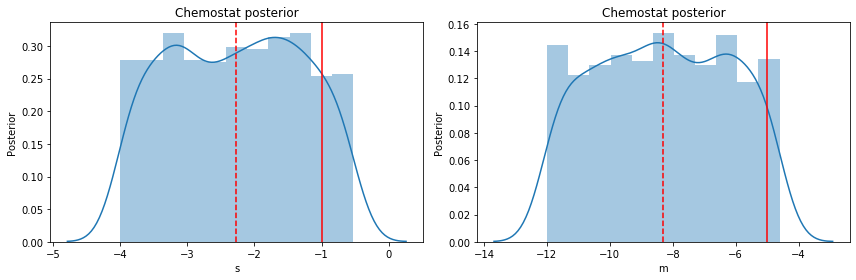

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for param_name, param_real_value, ax in zip(['s', 'm'], true_params, axes.flat):
    sns.distplot(params[param_name], hist_kws=dict(weights=weights), ax=ax)
    ax.axvline(param_real_value, color='red')
    ax.axvline(params[param_name].values @ weights, color='red', ls='--')
    ax.set(xlabel=param_name, ylabel='Posterior', title="Chemostat posterior")

fig.tight_layout()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

INFO:root:
Unfortunately, your original traceback can not be constructed.



Optimization terminated successfully.
         Current function value: -0.046573
         Iterations: 24
         Function evaluations: 48
Traceback (most recent call last):
  File "/Users/graceavecilla/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-21-028bf12727f4>", line 30, in <module>
    plt.savefig("Chemostat_ABC_posterior.pdf")
  File "/Users/graceavecilla/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py", line 729, in savefig
    res = fig.savefig(*args, **kwargs)
  File "/Users/graceavecilla/opt/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py", line 2180, in savefig
    self.canvas.print_figure(fname, **kwargs)
  File "/Users/graceavecilla/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backend_bases.py", line 2091, in print_figure
    **kwargs)
  File "/Users/graceavecilla/opt/anaconda3/lib/python3.7/site-packages/matp

FileNotFoundError: [Errno 2] No such file or directory: 'Chemostat_ABC_posterior.pdf'

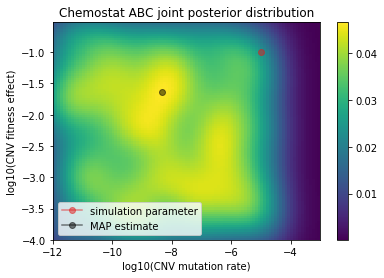

In [21]:
red, blue, green = sns.color_palette('Set1', 3)

prior_min = np.log10(np.array([1e-4,1e-12]))
prior_max = np.log10(np.array([0.3,1e-3]))

s_range, μ_range = np.mgrid[np.log10(1e-4):np.log10(0.3):100j, np.log10(1e-12):np.log10(1e-3):100j]
positions = np.vstack([s_range.ravel(), μ_range.ravel()])
values = np.vstack([params['s'], params['m']])
kernel = scipy.stats.gaussian_kde(values)
density = np.reshape(kernel(positions).T, s_range.shape)


#estimates for parameters from the posterior (MAP - highest probability in posterior)
idx = np.argmax(density, axis=None)
param_guess = np.array([positions[0,idx],positions[1,idx]])
def kernelminus(x):
    return -kernel(x)
s_est, μ_est = scipy.optimize.minimize(kernelminus,param_guess, method ='Nelder-Mead', 
 options={'disp': True}).x

#fig, axes = plt.subplots(1, 1, figsize=(10, 10))
plt.pcolormesh(μ_range, s_range, density)
plt.colorbar()
plt.plot(true_params[1],true_params[0], color=red, marker='o', label="simulation parameter", alpha=0.5)
plt.plot(μ_est, s_est, color="k", marker='o', label="MAP estimate", alpha=0.5)
plt.legend(loc='lower left')
plt.xlabel('log10(CNV mutation rate)')
plt.ylabel('log10(CNV fitness effect)')
plt.title("Chemostat ABC joint posterior distribution")
plt.savefig("Chemostat_ABC_posterior.pdf")